In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [4]:
try:
    df = pd.read_csv('/content/customer_segmentation.csv', encoding='latin-1')
except UnicodeDecodeError:
    # If 'latin-1' doesn't work, try 'cp1252'
    try:
        df = pd.read_csv('/content/customer_segmentation.csv', encoding='cp1252')
    except UnicodeDecodeError:
        print("Could not decode the file with 'latin-1' or 'cp1252'. Please check the file encoding.")

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.shape

(541909, 8)

In [7]:
# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [10]:
df = df.dropna(subset=['CustomerID'])

In [11]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [14]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)




In [15]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': ['sum', 'mean']                             # Monetary, AOV
})



In [16]:
rfm.columns = ['Recency', 'Frequency', 'Monetary', 'AOV']
rfm.reset_index(inplace=True)


In [17]:

# Define LTV as total Monetary value (can be modified to more complex logic)
rfm['LTV'] = rfm['Monetary']

In [18]:
from sklearn.model_selection import train_test_split

X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['LTV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


MAE: 1174.9076757751072
RMSE: 6178.590359019411


In [21]:
rfm['Predicted_LTV'] = model.predict(X)

# Segment customers
rfm['Segment'] = pd.qcut(rfm['Predicted_LTV'], 4, labels=['Low', 'Mid', 'High', 'Very High'])

rfm.to_csv("ltv_predictions.csv", index=False)


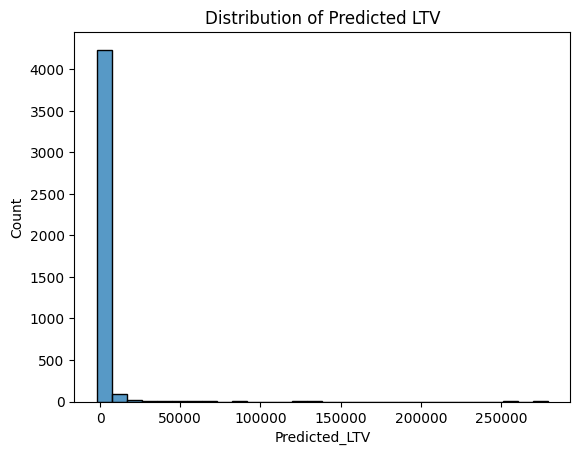

<Axes: xlabel='Segment', ylabel='Predicted_LTV'>

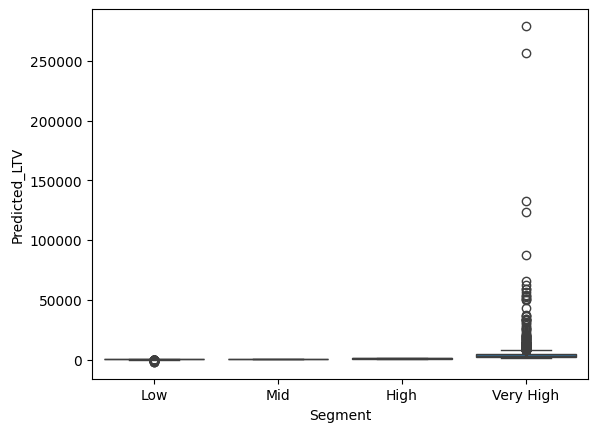

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(rfm['Predicted_LTV'], bins=30)
plt.title("Distribution of Predicted LTV")
plt.show()

sns.boxplot(x='Segment', y='Predicted_LTV', data=rfm)


Text(0.5, 1.0, 'Original LTV Distribution')

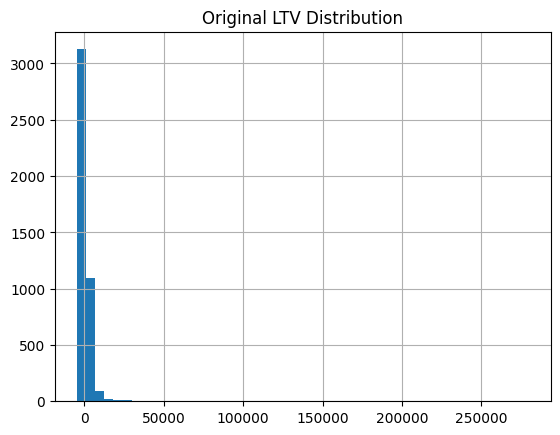

In [23]:
import matplotlib.pyplot as plt
rfm['LTV'].hist(bins=50)
plt.title("Original LTV Distribution")


In [25]:
cap_value = rfm['LTV'].quantile(0.95)  # Cap at 95th percentile
rfm['LTV_Capped'] = np.where(rfm['LTV'] > cap_value, cap_value, rfm['LTV'])



In [26]:
rfm['Log_LTV'] = np.log1p(rfm['LTV_Capped'])  # log(1 + x) handles 0s


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Import numpy

features = ['Recency', 'Frequency', 'AOV']
X = rfm[features]
y = rfm['Log_LTV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for and remove infinite or NaN values from the training data
# Create a boolean mask for rows in y_train that are finite
finite_mask_train = np.isfinite(y_train)

# Apply the mask to both X_train and y_train
X_train_cleaned = X_train[finite_mask_train]
y_train_cleaned = y_train[finite_mask_train]

# Now train the model with the cleaned data
model = XGBRegressor()
model.fit(X_train_cleaned, y_train_cleaned)

# Predict and inverse log
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Convert log back

# Evaluate
actual = np.expm1(y_test)

# Check for and remove non-finite values in actual and y_pred before calculating metrics
# Create a boolean mask for rows where both actual and y_pred are finite
valid_predictions_mask = np.isfinite(actual) & np.isfinite(y_pred)

# Apply the mask to both actual and y_pred for evaluation
actual_cleaned_eval = actual[valid_predictions_mask]
y_pred_cleaned_eval = y_pred[valid_predictions_mask]


# Calculate metrics using the cleaned evaluation data
mae = mean_absolute_error(actual_cleaned_eval, y_pred_cleaned_eval)
rmse = np.sqrt(mean_squared_error(actual_cleaned_eval, y_pred_cleaned_eval))

print(f"Improved MAE: {mae:.2f}")
print(f"Improved RMSE: {rmse:.2f}")

Improved MAE: 503.48
Improved RMSE: 846.49


In [30]:
rfm['Predicted_LTV'] = np.expm1(model.predict(X))  # Convert back from log
rfm['Segment'] = pd.qcut(rfm['Predicted_LTV'], 4, labels=['Low', 'Mid', 'High', 'Very High'])

rfm[['CustomerID', 'Recency', 'Frequency', 'AOV', 'Predicted_LTV', 'Segment']].to_csv("ltv_predictions_final.csv", index=False)


Text(0.5, 1.0, 'LTV by Segment')

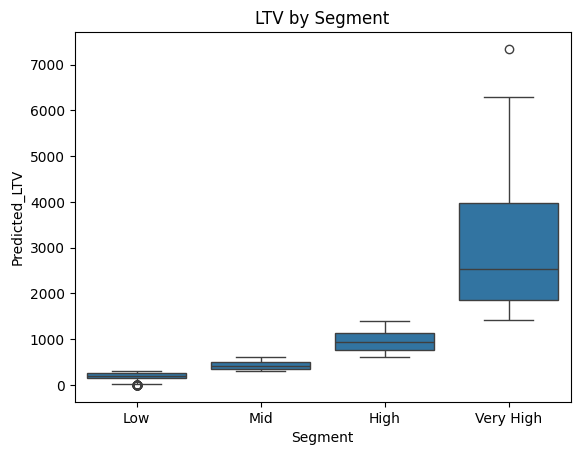

In [31]:
import seaborn as sns
sns.boxplot(x='Segment', y='Predicted_LTV', data=rfm)
plt.title("LTV by Segment")


In [34]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Import numpy
import pandas as pd # Import pandas (needed for qcut)

# Assuming 'rfm' DataFrame and the 'features', 'X', 'y',
# 'X_train', 'X_test', 'y_train', 'y_test' variables are already defined
# from previous cells.

# --- Start of fix ---
# Clean X_train and y_train to remove rows with non-finite values
finite_mask_train = np.isfinite(y_train)
X_train_cleaned = X_train[finite_mask_train]
y_train_cleaned = y_train[finite_mask_train]

# It's also good practice to ensure X_train is clean, although the error
# points to y_train. Let's check features in X_train too.
# Create a mask for rows in X_train where all values are finite
finite_mask_X_train = X_train_cleaned.apply(np.isfinite).all(axis=1)

# Apply this mask to both X_train_cleaned and y_train_cleaned
X_train_cleaned = X_train_cleaned[finite_mask_X_train]
y_train_cleaned = y_train_cleaned[finite_mask_X_train]
# --- End of fix ---


xgb = XGBRegressor(objective='reg:squarederror')

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

random_search = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=20, cv=3,
                                   scoring='neg_mean_absolute_error',
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV with the cleaned training data
random_search.fit(X_train_cleaned, y_train_cleaned) # Use cleaned data here
best_xgb = random_search.best_estimator_

# Predict on the original (potentially uncleaned) X_test for evaluation
y_pred_tuned = np.expm1(best_xgb.predict(X_test))

# Evaluate using the actual and predicted values after inverse transformation
# Ensure actual values from y_test are also inverse transformed
actual_eval = np.expm1(y_test)

# It's best practice to handle potential non-finite values in actual_eval and y_pred_tuned
# before calculating metrics, especially since you saw issues with the label.
valid_eval_mask = np.isfinite(actual_eval) & np.isfinite(y_pred_tuned)
actual_eval_cleaned = actual_eval[valid_eval_mask]
y_pred_tuned_cleaned = y_pred_tuned[valid_eval_mask]


print("Tuned MAE:", mean_absolute_error(actual_eval_cleaned, y_pred_tuned_cleaned))

# --- Start of fix ---
# Calculate MSE and then take the square root to get RMSE
tuned_mse = mean_squared_error(actual_eval_cleaned, y_pred_tuned_cleaned)
print("Tuned RMSE:", np.sqrt(tuned_mse))
# --- End of fix ---

# Note: If you plan to use the tuned model for predictions on the full dataset
# or other uncleaned data, you should apply the same cleaning steps to that data
# or handle non-finite values appropriately before prediction.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tuned MAE: 463.9210016085476
Tuned RMSE: 795.2302802393918


In [35]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_pred = np.expm1(rf.predict(X_test))

lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.05)
lgbm.fit(X_train, y_train)
lgbm_pred = np.expm1(lgbm.predict(X_test))

print("RF MAE:", mean_absolute_error(np.expm1(y_test), rf_pred))
print("LGBM MAE:", mean_absolute_error(np.expm1(y_test), lgbm_pred))


ValueError: Input y contains NaN.

In [36]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import numpy as np # Import numpy
import pandas as pd # Import pandas (needed for qcut, though not directly used in this cell)

# Assuming 'rfm' DataFrame and the 'features', 'X', 'y',
# 'X_train', 'X_test', 'y_train', 'y_test' variables are already defined
# from previous cells.

# --- Start of fix ---
# Clean X_train and y_train to remove rows with non-finite values
# Create a boolean mask for rows in y_train that are finite
finite_mask_train = np.isfinite(y_train)

# Apply the mask to both X_train and y_train
X_train_cleaned = X_train[finite_mask_train]
y_train_cleaned = y_train[finite_mask_train]

# It's also good practice to ensure X_train is clean.
# Create a mask for rows in X_train_cleaned where all values are finite
finite_mask_X_train = X_train_cleaned.apply(np.isfinite).all(axis=1)

# Apply this mask to both X_train_cleaned and y_train_cleaned
X_train_cleaned = X_train_cleaned[finite_mask_X_train]
y_train_cleaned = y_train_cleaned[finite_mask_X_train]

# --- End of fix ---


rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
# Fit RandomForestRegressor with the cleaned training data
rf.fit(X_train_cleaned, y_train_cleaned)
rf_pred = np.expm1(rf.predict(X_test))

lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.05)
# Fit LGBMRegressor with the cleaned training data
lgbm.fit(X_train_cleaned, y_train_cleaned)
lgbm_pred = np.expm1(lgbm.predict(X_test))

# For evaluation, we should use the cleaned actual values derived from y_test
# similar to how it was done for the XGBoost evaluation.
actual_eval = np.expm1(y_test)

# It's best practice to handle potential non-finite values in actual_eval and predictions
valid_eval_mask_rf = np.isfinite(actual_eval) & np.isfinite(rf_pred)
actual_eval_cleaned_rf = actual_eval[valid_eval_mask_rf]
rf_pred_cleaned_eval = rf_pred[valid_eval_mask_rf]


valid_eval_mask_lgbm = np.isfinite(actual_eval) & np.isfinite(lgbm_pred)
actual_eval_cleaned_lgbm = actual_eval[valid_eval_mask_lgbm]
lgbm_pred_cleaned_eval = lgbm_pred[valid_eval_mask_lgbm]


# Calculate metrics using the cleaned evaluation data
print("RF MAE:", mean_absolute_error(actual_eval_cleaned_rf, rf_pred_cleaned_eval))
print("LGBM MAE:", mean_absolute_error(actual_eval_cleaned_lgbm, lgbm_pred_cleaned_eval))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 3463, number of used features: 3
[LightGBM] [Info] Start training from score 6.512723
RF MAE: 460.6852467331762
LGBM MAE: 466.3405682612987


In [37]:
import pandas as pd
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Customer first & last purchase dates
customer_dates = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
customer_dates['Tenure'] = (customer_dates['max'] - customer_dates['min']).dt.days
customer_dates['DaysActive'] = df.groupby('CustomerID')['InvoiceDate'].nunique()

# Merge back
rfm = rfm.merge(customer_dates[['Tenure', 'DaysActive']], on='CustomerID', how='left')


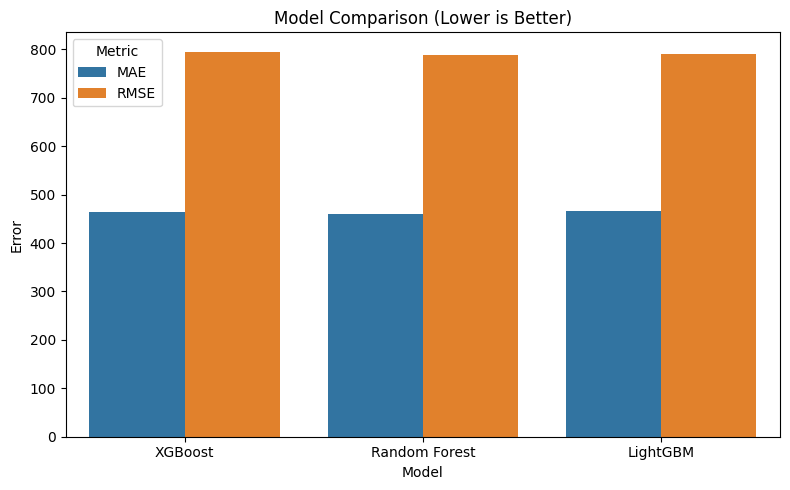

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd # Ensure pandas is imported if needed elsewhere, although not strictly for this cell

# Actual LTV values (inverse transformed)
actual = np.expm1(y_test)

# Predictions (inverse transformed)
models = {
    'XGBoost': np.expm1(best_xgb.predict(X_test)),
    'Random Forest': np.expm1(rf.predict(X_test)), # Ensure rf.predict is inverse transformed
    'LightGBM': np.expm1(lgbm.predict(X_test)) # Ensure lgbm.predict is inverse transformed
}

# Calculate MAE and RMSE
results = []
for name, pred in models.items():
    # --- Start of Fix ---
    # Create a mask for rows where both actual and pred are finite
    valid_mask = np.isfinite(actual) & np.isfinite(pred)

    # Apply the mask to both actual and pred for evaluation
    actual_cleaned_eval = actual[valid_mask]
    pred_cleaned_eval = pred[valid_mask]

    # Check if there are still valid data points after cleaning
    if len(actual_cleaned_eval) == 0:
        print(f"Warning: No valid data points left for {name} after cleaning. Skipping metric calculation.")
        mae = np.nan # Or some other indicator
        rmse = np.nan
    else:
        # Calculate metrics using the cleaned evaluation data
        mae = mean_absolute_error(actual_cleaned_eval, pred_cleaned_eval)
        rmse = np.sqrt(mean_squared_error(actual_cleaned_eval, pred_cleaned_eval))
    # --- End of Fix ---

    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse})

# Create DataFrame
results_df = pd.DataFrame(results)

# Melt for plotting (handle potential NaNs in results_df if any models had no valid data)
results_melted = results_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE']).dropna(subset=['value'])


# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=results_melted, x='Model', y='value', hue='variable')
plt.title("Model Comparison (Lower is Better)")
plt.ylabel("Error")
plt.xlabel("Model")
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

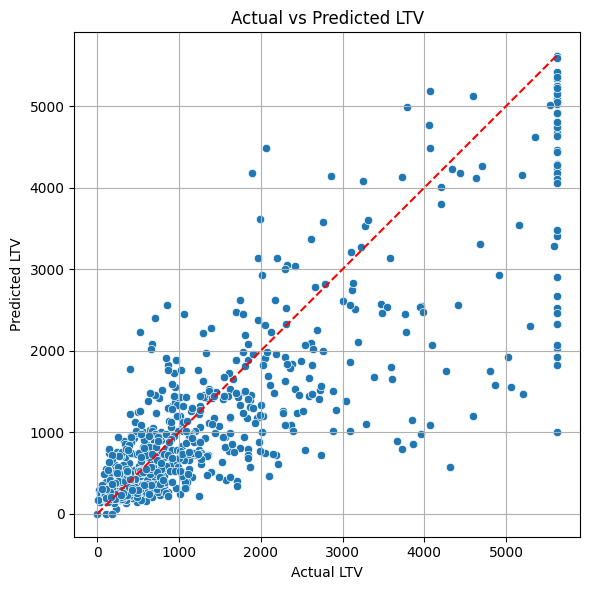

In [41]:
best_pred = models['XGBoost']  # or whichever was best

plt.figure(figsize=(6, 6))
sns.scatterplot(x=actual, y=best_pred)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
plt.title("Actual vs Predicted LTV")
plt.xlabel("Actual LTV")
plt.ylabel("Predicted LTV")
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
results_df.to_csv("model_comparison_metrics.csv", index=False)
